In [1]:
!pip freeze | grep -E "qiskit|prototype-zne|numpy"

numpy==1.26.4
prototype-zne==1.3.1
qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2


In [2]:
from qiskit.transpiler import generate_preset_pass_manager, CouplingMap
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

from numpy.random import default_rng
from numpy import sqrt, mean, pi
import numpy as np

In [3]:
def build_qaoa_circuit(
    num_qubits: int,
    depth: int,
    measurements: bool = True,
    barriers: bool = False,
) -> QuantumCircuit:
    """Build parameterized QAOA quantum circuit.

    Args:
        num_qubits: number of qubits.
        depth: two-qubit depth (needs to be even).
        measurements: if True adds measurements at the end.
        barriers: if True adds barriers between layers.
    Returns:
        A dense QAOA quantum circuit for a linear, non-cyclic, graph
        with cost parameter-vector γ, and mixer parameter-vector β.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if depth % 2 != 0:
        raise ValueError("Depth must be even.")

    gammas = ParameterVector("γ", depth // 2)
    betas = ParameterVector("β", depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            circuit.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    if measurements:
        circuit.measure_all()
    return circuit


def produce_qaoa_parameters(num_layers, *, seed=None):
    """Produce random QAOA parameters.
    Args:
        num_layers: the number of QAOA layers.
        seed: a seed to generate the random angles.
    Returns:
        A tuple holding the beta and gamma angles.
    """
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()
    return betas, gammas


def build_compute_uncompute_qaoa_circuit(
    num_qubits: int,
    depth: int,
    *,
    measurements: bool = True,
    barriers: bool = False,
) -> QuantumCircuit:
    """Build a parametrized compute-uncompute QAOA quantum circuit."""
    if depth % 4 != 0:
        raise ValueError("Depth must be a multiple of four.")

    qaoa = build_qaoa_circuit(
        num_qubits, depth // 2, measurements=False, barriers=barriers
    )

    circuit = QuantumCircuit(num_qubits)
    circuit.compose(qaoa, inplace=True)
    circuit.barrier()
    circuit.compose(qaoa.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)

    return circuit

In [4]:
num_qubits = 12
p = 1  # QAOA terminology
shots = 10000

observables = []

# Considering only wt-1 observables for brevity
for i in range(num_qubits):
    obs = "I" * i + "Z" * 1 + "I" * (num_qubits - i - 1)
    observables.append(obs)

In [5]:
observables

['ZIIIIIIIIIII',
 'IZIIIIIIIIII',
 'IIZIIIIIIIII',
 'IIIZIIIIIIII',
 'IIIIZIIIIIII',
 'IIIIIZIIIIII',
 'IIIIIIZIIIII',
 'IIIIIIIZIIII',
 'IIIIIIIIZIII',
 'IIIIIIIIIZII',
 'IIIIIIIIIIZI',
 'IIIIIIIIIIIZ']

In [6]:
qc = build_compute_uncompute_qaoa_circuit(num_qubits, 4 * p)

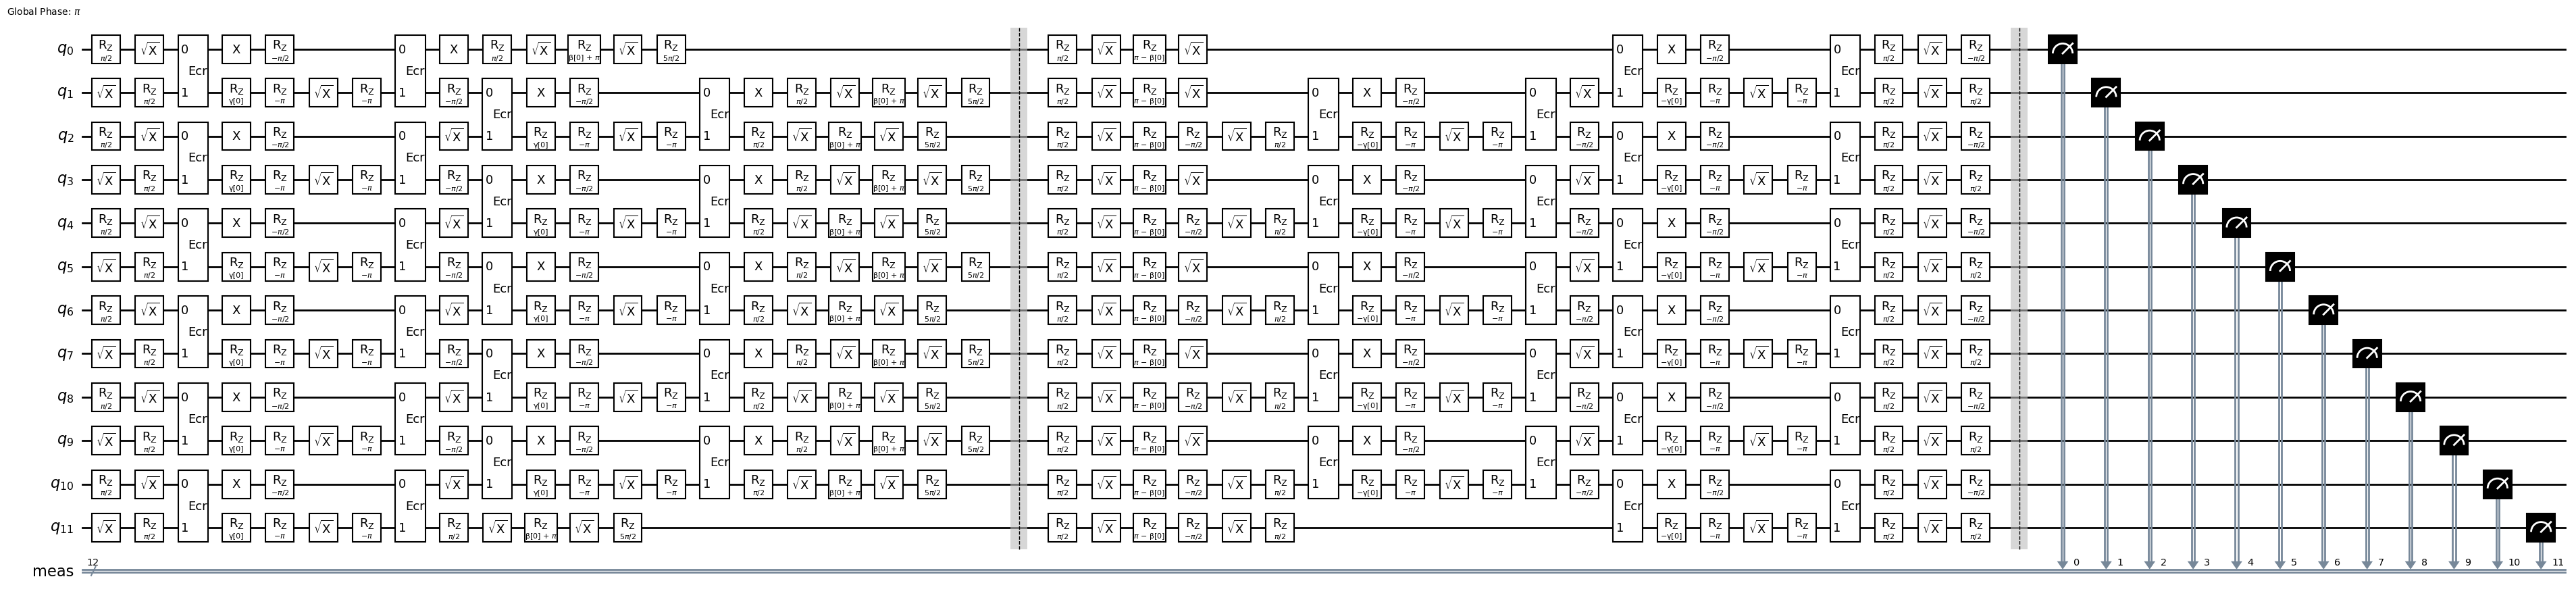

In [7]:
pm = generate_preset_pass_manager(2, basis_gates=["x", "sx", "rz", "ecr", "id"])

qc = pm.run(qc)
qc.draw("mpl", style="bw", fold=-1)

In [8]:
betas, gammas = produce_qaoa_parameters(p, seed=0)
params = [gammas[0], betas[0]]
params

[-1.4464727375963786, 0.8605556614246863]

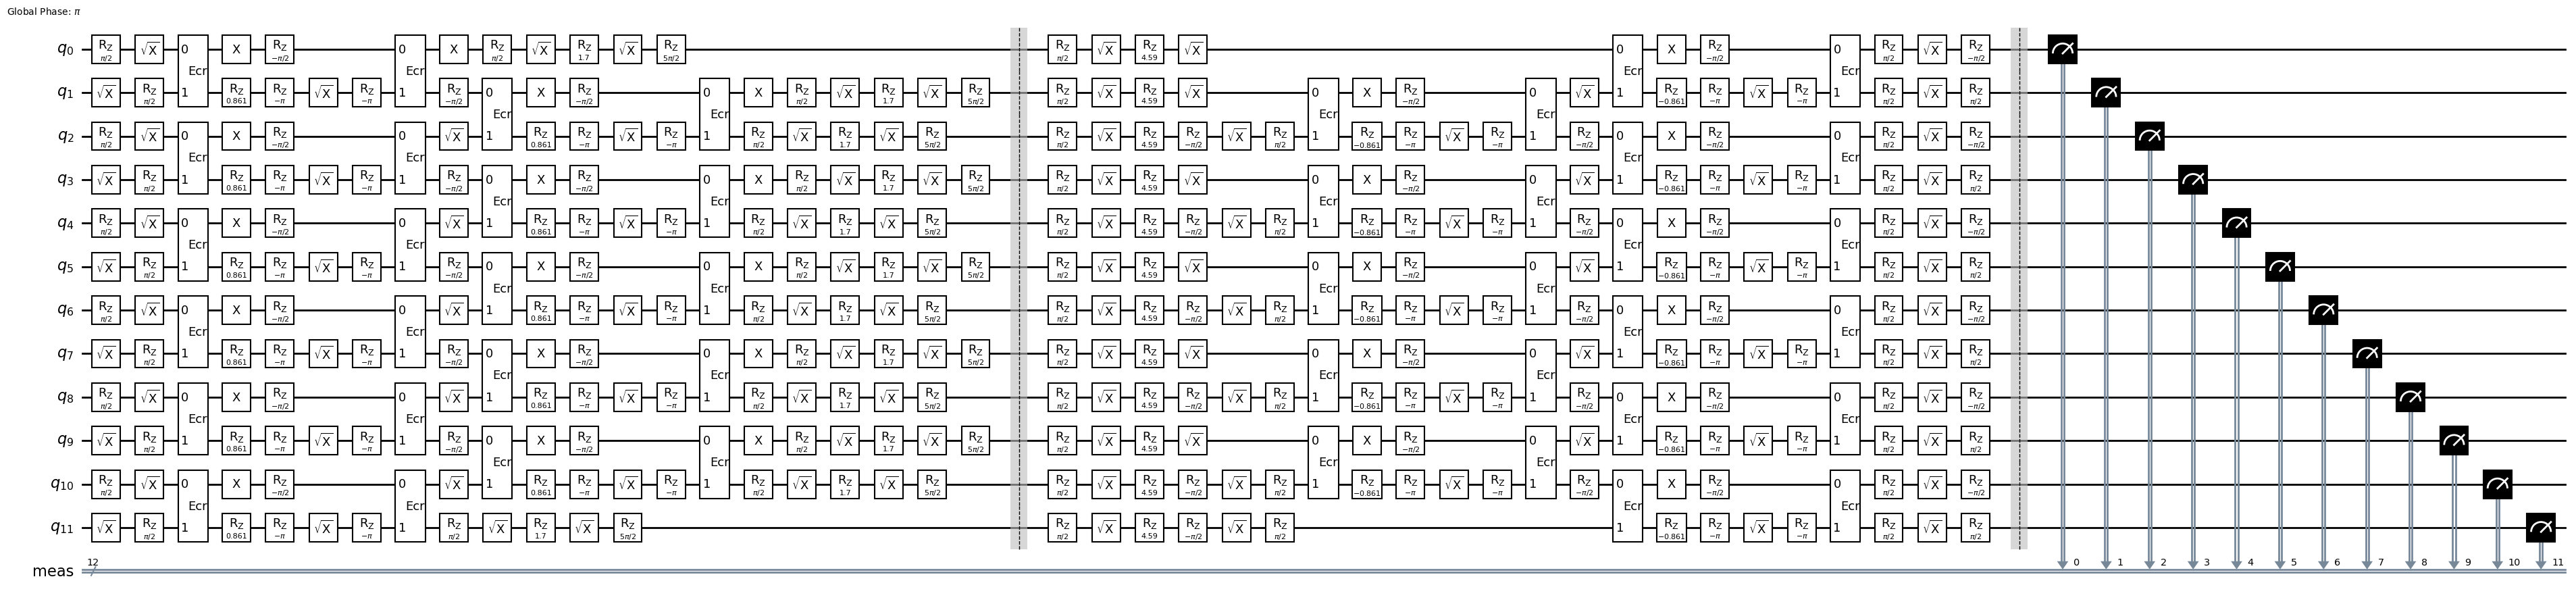

In [9]:
qc = qc.assign_parameters(params)
qc.draw("mpl", style="bw", fold=-1)

### ZNE for a depolarization noise environment

In [10]:
def create_depolarization_error(p_depol: float) -> NoiseModel:
    noise_model = NoiseModel()
    error = depolarizing_error(p_depol, 2)
    noise_model.add_all_qubit_quantum_error(error, ["cx"])
    return noise_model

In [11]:
backend = GenericBackendV2(
    num_qubits=num_qubits,
    basis_gates=["x", "sx", "rz", "ecr", "id"],
    coupling_map=CouplingMap.from_line(num_qubits),
)

noise_model = create_depolarization_error(0.01)
backend.set_options(**{"noise_model": noise_model})

#### First we check the noisy outcome without any mitigation

In [12]:
noisy_count = backend.run(qc, shots=shots).result().get_counts()

In [13]:
noisy_count

{'000010000110': 1,
 '011100000100': 1,
 '100110000000': 1,
 '110100000100': 1,
 '001110010000': 1,
 '000000100100': 1,
 '000100001100': 1,
 '110000010000': 2,
 '110000000100': 2,
 '111100000000': 7,
 '000001100011': 1,
 '001110000001': 1,
 '000011011000': 1,
 '000100000001': 2,
 '000100010000': 2,
 '100000001000': 3,
 '000001001100': 1,
 '010010000000': 2,
 '000001010000': 1,
 '001100001000': 1,
 '010011000000': 1,
 '110000000010': 1,
 '001001010000': 1,
 '000000111000': 7,
 '001000001100': 2,
 '001010001000': 2,
 '000000001011': 2,
 '001100011000': 1,
 '110001000000': 1,
 '000011010000': 2,
 '000010000010': 2,
 '001000111000': 1,
 '011001000000': 1,
 '011000010000': 1,
 '100000001100': 2,
 '000000001001': 4,
 '001100000101': 1,
 '000010001100': 1,
 '110010000000': 1,
 '010000000100': 1,
 '101000000000': 16,
 '001011100000': 1,
 '001100000011': 3,
 '000100011000': 1,
 '000000000000': 7984,
 '000000110011': 1,
 '000010101100': 1,
 '000000011100': 3,
 '011000000001': 2,
 '000000101010':

#### Calculate the expectation values of the observables

In [14]:
expvals = []

for obs in observables:
    expval = sampled_expectation_value(noisy_count, obs)
    expvals.append(expval)

avg_expval = mean(expvals)

In [15]:
avg_expval

0.9467

### Zero Noise Extrapolation

#### Amplify the circuit

In [16]:
from zne.noise_amplification import TwoQubitAmplifier

In [17]:
NOISE_FACTORS = [1, 3, 5]
NOISE_AMPLIFIER = TwoQubitAmplifier(sub_folding_option="random", random_seed=0)

In [18]:
def amplify_noise(qc: QuantumCircuit, nf, noise_amplifier) -> QuantumCircuit:
    if nf == 1:
        return qc
    else:
        return noise_amplifier.amplify_circuit_noise(qc, nf)

In [19]:
def create_amplified_circuits(
    qc: QuantumCircuit, NOISE_FACTORS: list, NOISE_AMPLIFIER
) -> dict:
    zne_circuits = {nf: amplify_noise(qc, nf, NOISE_AMPLIFIER) for nf in NOISE_FACTORS}
    return zne_circuits

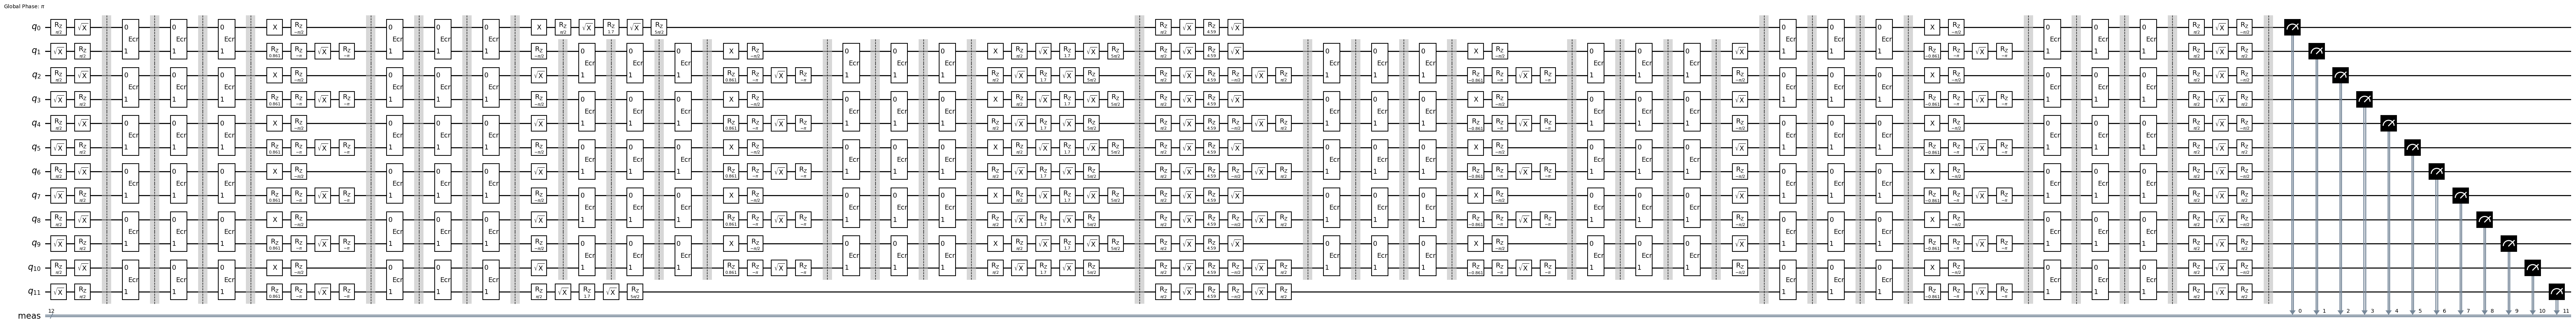

In [20]:
zne_circuits = create_amplified_circuits(qc, NOISE_FACTORS, NOISE_AMPLIFIER)
zne_circuits[3].draw("mpl", style="bw", fold=-1)

In [21]:
def get_amplified_counts(zne_circuits: dict, backend) -> dict:
    zne_counts = {
        nf: backend.run(zne_circuits[nf], shots=shots).result().get_counts()
        for nf in list(zne_circuits.keys())
    }
    return zne_counts

In [22]:
zne_counts = get_amplified_counts(zne_circuits, backend)

In [23]:
def get_amplified_expvals(zne_counts: dict) -> dict:
    zne_expvals = {}

    for nf in list(zne_counts.keys()):
        expvals_amplified = []
        for obs in observables:
            expval_ = sampled_expectation_value(zne_counts[nf], obs)
            expvals_amplified.append(expval_)
        zne_expvals[nf] = mean(expvals_amplified)

    return zne_expvals

In [24]:
zne_expvals = get_amplified_expvals(zne_counts)
zne_expvals

{1: 0.9485333333333333, 3: 0.8679833333333332, 5: 0.7948166666666667}

#### Extrapolate to zero noise

In [25]:
from zne.extrapolation import *

In [26]:
extrapolator = LinearExtrapolator()

In [27]:
extrapolated_mean = extrapolator.extrapolate_zero(
    list(zne_expvals.keys()), list(zne_expvals.values())
)

In [28]:
extrapolated_mean.value

0.9857319443549777

### Deeper circuits

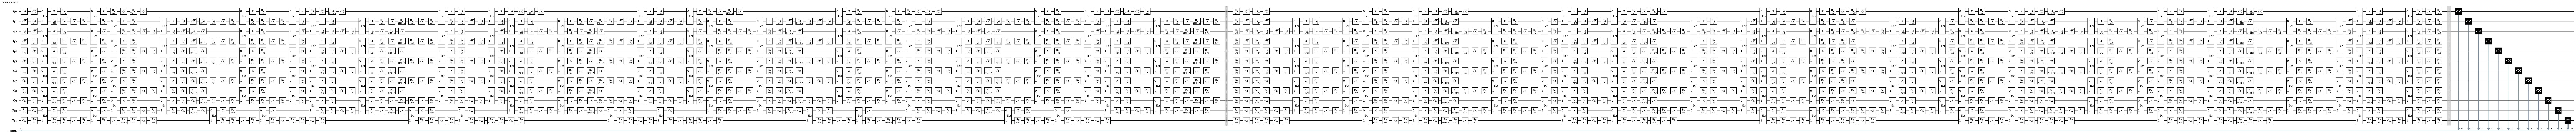

In [29]:
p = 6
qc_deep = build_compute_uncompute_qaoa_circuit(num_qubits, 4 * p)
qc_deep = pm.run(qc_deep)
qc_deep.draw("mpl", style="bw", fold=-1)

In [30]:
betas, gammas = produce_qaoa_parameters(p, seed=0)
params = [
    gammas[0],
    betas[0],
    gammas[1],
    betas[1],
    gammas[2],
    betas[2],
    gammas[3],
    betas[3],
    gammas[4],
    betas[4],
    gammas[5],
    betas[5],
]
params

[0.6700123395200417,
 0.8605556614246863,
 1.441969420022903,
 -1.4464727375963786,
 0.27410390540137985,
 -2.8841484100105235,
 2.7336406607023154,
 -3.03774645687452,
 1.9845664104768632,
 1.9683349641197863,
 -3.1243861495570098,
 2.5934197786078093]

In [31]:
qc_deep = qc_deep.assign_parameters(params)

#### Perform amplification and extrapolation as before

In [32]:
zne_circuits_deep = create_amplified_circuits(qc_deep, NOISE_FACTORS, NOISE_AMPLIFIER)

In [33]:
zne_counts_deep = get_amplified_counts(zne_circuits_deep, backend)

In [34]:
zne_expvals_deep = get_amplified_expvals(zne_counts_deep)
zne_expvals_deep

{1: 0.7100333333333332, 3: 0.39368333333333333, 5: 0.2225}

In [35]:
extrapolator = LinearExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(
    list(zne_expvals_deep.keys()), list(zne_expvals_deep.values())
)

In [36]:
extrapolated_mean_deep.value

0.8077222222222218

#### At this scale, a linear approximation is not sufficient. So we shift to exponential extrapolator

In [37]:
extrapolator = MonoExponentialExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(
    list(zne_expvals_deep.keys()), list(zne_expvals_deep.values())
)
extrapolated_mean_deep.value

0.9578150252723462

#### Also think of partial folding

In [38]:
NOISE_FACTORS = [1, 1.2, 1.4]
zne_circuits_deep = create_amplified_circuits(qc_deep, NOISE_FACTORS, NOISE_AMPLIFIER)

In [39]:
zne_circuits_deep[1.2].draw(fold=-1)

global phase: π
         ┌─────────┐   ┌────┐     ░       ┌──────┐        ░      ┌──────┐    ░     ┌──────┐     ░          ┌───┐      ┌──────────┐                         ┌──────┐    ┌───┐    ┌─────────┐    ┌────┐    ┌────────────┐    ┌────┐                                                                                                                                                                                                                ┌──────┐       ┌───┐       ┌──────────┐                           ┌──────┐      ┌───┐    ┌─────────┐     ┌────┐    ┌────────────┐    ┌────┐                                                                                                                            ┌──────┐      ┌───┐      ┌──────────┐                          ┌──────┐      ┌───┐    ┌─────────┐    ┌────┐    ┌────────────┐    ┌────┐                                                                                                                              ┌──────┐      ┌───┐      ┌──────────┐                              ┌──────┐      ┌───┐    ┌─────────┐    ┌────┐    ┌────────────┐   ┌────┐                                                                                                                                                                    ┌──────┐       ┌───┐       ┌──────────┐                              ┌──────┐     ┌───┐      ┌─────────┐     ┌────┐   ┌────────────┐    ┌────┐                                                                                                                                                                                                             ┌──────┐      ┌───┐      ┌──────────┐                                ░        ┌──────┐       ░       ┌──────┐        ░           ┌──────┐         ░          ┌───┐    ┌─────────┐    ┌────┐    ┌─────────────┐   ┌────┐  ┌──────────┐                                                                                                 ░ ┌─────────┐┌────┐┌────────────┐   ┌────┐                                                                                           ┌──────┐     ┌───┐     ┌──────────┐                ┌──────┐   ┌───┐   ┌─────────┐    ┌────┐    ┌────────────┐   ┌────┐                                                                                                                                                                                        ┌──────┐    ┌───┐     ┌──────────┐                            ░          ┌──────┐        ░         ┌──────┐         ░         ┌──────┐         ░          ┌───┐    ┌─────────┐     ┌────┐    ┌────────────┐   ┌────┐                                                                                                                                                               ┌──────┐        ┌───┐       ┌──────────┐                           ┌──────┐       ┌───┐     ┌─────────┐      ┌────┐     ┌────────────┐   ┌────┐                                                                                                                            ┌──────┐      ┌───┐      ┌──────────┐                               ┌──────┐      ┌───┐    ┌─────────┐    ┌────┐   ┌───────────┐   ┌────┐                                                                                                                                                              ┌──────┐     ┌───┐     ┌──────────┐                  ┌──────┐   ┌───┐    ┌─────────┐      ┌────┐    ┌────────────┐   ┌────┐                                                                                                                                  ░           ┌──────┐        ░       ┌──────┐        ░         ┌──────┐         ░            ┌───┐     ┌──────────┐                       ┌──────┐  ┌─────────┐     ┌────┐    ┌──────────┐                                                                                                 ░ ┌─┐                                 
    q_0: ┤ Rz(π/2) ├───┤ √X ├─────░───────┤0     ├────────░──────┤0     ├────░─────┤0     ├─────░──────────┤ X

In [40]:
zne_counts_deep = get_amplified_counts(zne_circuits_deep, backend)
zne_expvals_deep = get_amplified_expvals(zne_counts_deep)
zne_expvals_deep

{1: 0.7120166666666666, 1.2: 0.67565, 1.4: 0.6304}

The expectation values with partial folding are much better than the previous scenario

In [41]:
extrapolator = LinearExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(
    list(zne_expvals_deep.keys()), list(zne_expvals_deep.values())
)

In [42]:
extrapolated_mean_deep.value

0.9175388897369096

In [43]:
extrapolator = PolynomialExtrapolator(degree=2)
extrapolated_mean_deep = extrapolator.extrapolate_zero(
    list(zne_expvals_deep.keys()), list(zne_expvals_deep.values())
)
extrapolated_mean_deep.value

0.7605999999999976